In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate
from keras.models import Model
from keras.optimizers import Adagrad

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import reyesIronyVsEducation

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/finalTests/'

In [4]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

In [5]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

In [9]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


# Data

In [8]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = reyesIronyVsEducation()

In [10]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [11]:
train_pos =get_pos('output_trainTestData/reyes_i_e_train_pos.csv')
test_pos = get_pos('output_trainTestData/reyes_i_e_test_pos.csv')

In [12]:
train_senti_blob =get_sentiment('output_trainTestData/reyes_i_e_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/reyes_i_e_test_data_sentiment_blob.csv')

# The model

In [13]:
#The model
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(comment_input)
x_first = Dense(600, activation='relu')(embedded_sequences)
x_first = Flatten()(x_first)

#Second part
senti_input_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second = Dense(600, activation='relu')(senti_input_blob)

#Thrid part
senti_input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third = Dense(600, activation='relu')(senti_input_pos)

#Concatination
concat = concatenate([x_first, x_second, x_third])

preds = Dense(2, activation='softmax')(concat)

model = Model(inputs=[comment_input, senti_input_blob, senti_input_pos], outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 99)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 99, 300)      10193400    input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 99, 600)      180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 99)           0                                            
__________________________________________________________________________________________________
input_3 (I

# Test results

Instructions for updating:
Use tf.cast instead.


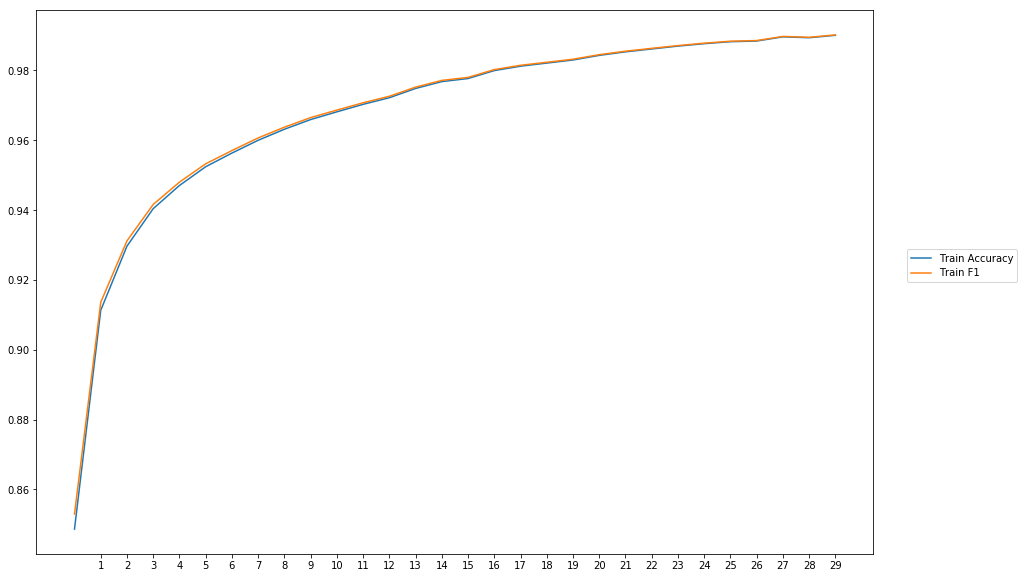


-----Test Scores----
Loss: 0.18761520093363343
Accuracy: 93.76262626262626
Precision: 93.05347325871797
Recall: 94.51776649266407
F1: 93.77989930180183


In [14]:
train_evaluate_three_inputs_with_terminate(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'ReyesIronyVsEducation')